## Part 3: BERT classification system for predicting ratings from reviews.

### Importing necessary package

In [65]:
# !pip install tensorflow_text

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text

# visualisation
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

pyo.init_notebook_mode()  

Output hidden; open in https://colab.research.google.com to view.

### Loading the beauty dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_beauty = pd.read_json('/content/drive/My Drive/Courses/AML/Assignment01/beauty_products_reviews.json', lines=True)
df_beauty

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5264,5,True,"08 23, 2018",AUX122XW8ONG6,B01DLR9IDI,{'Design:': ' ETA-C6B5F7C374'},Amzon Customer,I have genetic undereye darkness. Ive accepted...,Pretty Sweet!!!,1534982400,2,NaN
5265,5,True,"08 23, 2018",AUX122XW8ONG6,B01DLR9IDI,{'Design:': ' ETA-7117EE3788'},Amzon Customer,I absolutely love this eye gel.,As advertised,1534982400,NaN,NaN
5266,5,True,"08 23, 2018",AUX122XW8ONG6,B01DLR9IDI,{'Design:': ' ETA-BF66BD2F87'},Amzon Customer,The eye gel is easy to apply and I use it morn...,I'm very happy with,1534982400,NaN,NaN
5267,5,True,"08 23, 2018",AUX122XW8ONG6,B01DLR9IDI,{'Design:': ' ETA-03868FCB34'},Amzon Customer,Ok this eye gel is good stuff.,Does it's thing!,1534982400,NaN,NaN


### Creating a new dataframe with reviews and rating

In [4]:
reviews_ratings_df = df_beauty[['reviewText', 'overall']]
reviews_ratings_df = reviews_ratings_df.rename(columns = {'reviewText': 'review', 'overall': 'rating'})
reviews_ratings_df

,review,rating
0,As advertised. Reasonably priced,5
1,Like the oder and the feel when I put it on my...,5
2,I bought this to smell nice after I shave. Wh...,1
3,HEY!! I am an Aqua Velva Man and absolutely lo...,5
4,If you ever want to feel pampered by a shampoo...,5
...,...,...
5264,I have genetic undereye darkness. Ive accepted...,5
5265,I absolutely love this eye gel.,5
5266,The eye gel is easy to apply and I use it morn...,5
5267,Ok this eye gel is good stuff.,5


In [5]:
reviews_ratings_df.describe(include = 'all')

,review,rating
count,5264,5269.000000
unique,1363,NaN
top,Great product,NaN
freq,15,NaN
mean,NaN,4.771873
std,NaN,0.743204
min,NaN,1.000000
25%,NaN,5.000000
50%,NaN,5.000000
75%,NaN,5.000000


In [6]:
# dropping rows with null value
reviews_ratings_df = reviews_ratings_df.dropna(how='any',axis=0) 
reviews_ratings_df.isnull().any()

review    False
rating    False
dtype: bool

In [7]:
rating_count = reviews_ratings_df['rating'].value_counts()
(rating_count/sum(rating_count)) * 100

5    88.221884
4     6.306991
1     2.184650
3     2.070669
2     1.215805
Name: rating, dtype: float64

In [8]:
fig = px.bar(rating_count, labels = {'index': 'rating', 'value' : 'count'}, title = 'Plotting Rating Count')

fig.update_traces(marker_line=dict(width=1, color='DarkSlateGray'))
fig.update_layout(showlegend= False)

fig.show(renderer='colab')

Almost 88% of the data has rating of 5. This implies that the data is heavily skewed towards positive ratings.

In [9]:
reviews_ratings_df

,review,rating
0,As advertised. Reasonably priced,5
1,Like the oder and the feel when I put it on my...,5
2,I bought this to smell nice after I shave. Wh...,1
3,HEY!! I am an Aqua Velva Man and absolutely lo...,5
4,If you ever want to feel pampered by a shampoo...,5
...,...,...
5264,I have genetic undereye darkness. Ive accepted...,5
5265,I absolutely love this eye gel.,5
5266,The eye gel is easy to apply and I use it morn...,5
5267,Ok this eye gel is good stuff.,5


In [10]:
# splitting the dataset into training and test set (70-30). Taking reviews as x and ratings as y

x_train, x_test, y_train, y_test = train_test_split(reviews_ratings_df['review'], reviews_ratings_df['rating'], test_size=0.2,random_state=25, shuffle=True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4211,) (4211,)
(1053,) (1053,)


In [11]:
print(x_train)
print(y_train)

4104    I just LOVE this body wash.  The smell is so f...
3565                                           Love this!
517                                                Nice!!
683     One liter almost lasted a year.... I forgot ho...
3783    My main powder brush now :D I like that it is ...
                              ...                        
255     My "go to" shampoo for my blonde foiled hair. ...
2937    Have used this fragrance for years now; just l...
2193    Sadly, mine wouldn't stay stuck to my bathtub,...
318     Smells amazing. I had to double bleach and my ...
5257    I love this lotion.  It has a light clean smel...
Name: review, Length: 4211, dtype: object
4104    5
3565    5
517     5
683     5
3783    5
       ..
255     5
2937    5
2193    3
318     5
5257    5
Name: rating, Length: 4211, dtype: int64


In [12]:
train_count = [0] * 5
test_count = [0] * 5

for i in y_train:
  train_count[i-1] = train_count[i-1] + 1

for j in y_test:
  test_count[j-1] = test_count[j-1] + 1

train_count = np.array(train_count)
test_count = np.array(test_count)

print(train_count/train_count.sum() * 100)
print(test_count/test_count.sum() * 100)

[ 2.27974353  1.13987176  2.01852292  6.50676799 88.0550938 ]
[ 1.80436847  1.51946819  2.27920228  5.50807217 88.88888889]


Splitting has happened in a balanced way.

In [13]:
# one-hot encoding of y 

enc = OneHotEncoder()

y_train_temp = y_train.to_numpy()
y_test_temp = y_test.to_numpy()

#y_train
enc.fit(y_train_temp.reshape(-1,1))
print(f"Categories: {enc.categories_}")
y_train_onehot = enc.transform(y_train_temp.reshape(-1,1)).toarray()
print(y_train)
print(y_train_onehot)

#y_test
print()

enc.fit(y_test_temp.reshape(-1,1))
print(f"Categories: {enc.categories_}")
y_test_onehot = enc.transform(y_test_temp.reshape(-1,1)).toarray()
print(y_test)
print(y_test_onehot)


Categories: [array([1, 2, 3, 4, 5])]
4104    5
3565    5
517     5
683     5
3783    5
       ..
255     5
2937    5
2193    3
318     5
5257    5
Name: rating, Length: 4211, dtype: int64
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]

Categories: [array([1, 2, 3, 4, 5])]
4405    5
2716    5
2803    5
2120    5
1453    5
       ..
1394    5
3792    5
4480    5
1213    5
935     5
Name: rating, Length: 1053, dtype: int64
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


### Loading the Bert Prepocessor and Base Uncased Encoder 

In [14]:
bert_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name = 'Preprocessing')
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2", name = 'Encoder')

The Small Bert model has 4 layers, 512 hidden units, and 4 attention head.

### Building the Rating Classifer Model

In [15]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'Text Input Layer')
  preprocessed_text = bert_preprocessor(text_input)
  encoder_outputs = bert_model(preprocessed_text)
  nn = tf.keras.layers.Dropout(0.1, name='Dropout')(encoder_outputs['pooled_output'])
  nn = tf.keras.layers.Dense(5, activation='softmax', name='Classifier')(nn)
  return tf.keras.Model(text_input, nn)
                                    
classifier_model = build_classifier_model()

In [16]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text Input Layer (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 Preprocessing (KerasLayer)     {'input_type_ids':   0           ['Text Input Layer[0][0]']       
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

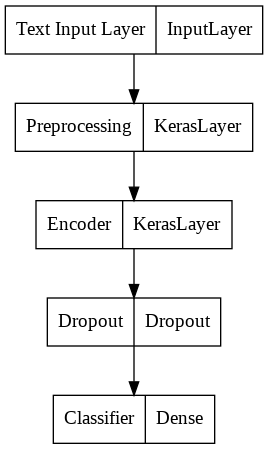

In [17]:
tf.keras.utils.plot_model(classifier_model)

In [18]:
# compiling the model

classifier_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_accuracy'])

In [19]:
x_train.shape

(4211,)

### Training the Classifier

In [20]:
# fitting the model
c_model = classifier_model.fit(x = x_train, y = y_train_onehot, batch_size = 64, validation_split = 0.1, epochs = 5)

Epoch 1/5
60/60 [==============================] - 303s 5s/step - loss: 0.7032 - categorical_accuracy: 0.8050 - val_loss: 0.3655 - val_categorical_accuracy: 0.9076
Epoch 2/5
60/60 [==============================] - 296s 5s/step - loss: 0.4448 - categorical_accuracy: 0.8775 - val_loss: 0.3268 - val_categorical_accuracy: 0.9100
Epoch 3/5
60/60 [==============================] - 294s 5s/step - loss: 0.4134 - categorical_accuracy: 0.8767 - val_loss: 0.3146 - val_categorical_accuracy: 0.9100
Epoch 4/5
60/60 [==============================] - 296s 5s/step - loss: 0.3859 - categorical_accuracy: 0.8794 - val_loss: 0.3066 - val_categorical_accuracy: 0.9123
Epoch 5/5
60/60 [==============================] - 296s 5s/step - loss: 0.3787 - categorical_accuracy: 0.8797 - val_loss: 0.2997 - val_categorical_accuracy: 0.9100


In [42]:
# getting training results

accuracy = c_model.history['categorical_accuracy']
val_accuracy = c_model.history['val_categorical_accuracy']
loss = c_model.history['loss']
val_loss = c_model.history['val_loss']
epochs = range(len(accuracy))

training_df = pd.DataFrame(epochs, columns = ['epochs'])
training_df['acc']= accuracy
training_df['val_acc']= val_accuracy
training_df['loss']= loss
training_df['val_loss']= val_loss

training_df

,epochs,acc,val_acc,loss,val_loss
0,0,0.804962,0.907583,0.703163,0.365546
1,1,0.877540,0.909953,0.444764,0.326753
2,2,0.876749,0.909953,0.413361,0.314639
3,3,0.879388,0.912322,0.385852,0.306553
4,4,0.879652,0.909953,0.378662,0.299741


In [60]:
# plotting training loss and accuracy vs validation loss and accuracy

fig = px.line(training_df, x = 'epochs', y = training_df.columns[3:5], title = 'Plotting Training Loss Graph', labels = {'value': 'Loss'}, markers = True)
fig.show(renderer = 'colab')


fig = px.line(training_df, x = 'epochs', y = training_df.columns[1:3], title = 'Plotting Training Loss Graph', labels = {'value': 'Accuracy'}, markers = True)
fig.show(renderer = 'colab')

Training loss and accuracy are moving in the same direction. So, there is no overfitting.

### Testing the Classifier

In [61]:
results = classifier_model.evaluate(x_test, y_test_onehot)

33/33 [==============================] - 83s 2s/step - loss: 0.3545 - categorical_accuracy: 0.8879


The Bert-based Rating prediction classifier has a testing accuracy of 89%.

In [64]:
# sample_dataset = [
#  'This is not a nice product. I hate it',
#  'Awesome Product. Really Good',
#  'I am dissappointed with the final product.',
#  'Worth Buying. I loved it.',
#  'I really like the product'
# ]

# classifier_model.predict(sample_dataset)